# Optimizing your Zoom background with RoomRater

In [77]:
import pandas as pd
import numpy as np
import json
import os
import io
from io import BytesIO

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import tweepy
from tweepy import Cursor

import re 

import requests
from PIL import Image
from matplotlib.pyplot import imshow

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
import sklearn
from sklearn.metrics import r2_score, accuracy_score, recall_score,precision_score
import imblearn
from imblearn.over_sampling import SMOTE
import seaborn as sns

random_state = 5

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laure\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laure\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\laure\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\laure\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Data Collection

In [7]:
consumer_key = consumer_key
consumer_secret = consumer_secret
access_token = access_token
access_secret = access_secret

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [8]:
# Collect tweets from @ratemyskyperoom 

def get_tweets(num_tweets):
    
    max_tweets = num_tweets
    
    tweet_count = 0
    errors = 0
    max_seq_errors = 2000

    tweets = []

    for status in Cursor(api.user_timeline, 
                         id='ratemyskyperoom', 
                         screen_name='Room Rater',
                         exclude_replies=True).items():

        if tweet_count == max_tweets:
            break

        if errors == max_seq_errors:
            break
        
        # Include the media url for visual analysis of backgrounds
        try: 
            tweet_id = status.id
            tweet_text = status.text
            image_url = status.entities.get('media')[0]['media_url']
            favorites = status.favorite_count

            tweet = {'tweet_id':tweet_id,
                     'tweet_text':tweet_text,
                     'image_url':image_url,
                    'favorites':favorites}

            tweets.append(tweet)

        except:
            errors += 1
            continue

        tweet_count += 1
        errors = 0

    # Store as dataframe
    tweet_df = pd.DataFrame(tweets,
                           columns = ['tweet_id',
                                      'tweet_text',
                                      'image_url',
                                      'favorites'])

    return tweet_df

#Resource for reading media_url:
#https://miguelmalvarez.com/2015/03/03/download-the-pictures-from-a-twitter-feed-using-python/

In [ ]:
# Collect a batch of tweets
tweet_df = get_tweets(2000)

# Store for easy access 
tweet_df.to_csv('roomratertweets.csv', index=False)

In [9]:
# Collect and store more tweets after some time
tweet_df2 = get_tweets(2000)
tweet_df2.to_csv('roomratertweets2.csv', index=False)

## Loading Data

In [2]:
def load_data(tweet_filepath):
    """Input filepath for stored tweets and return dataframe"""
    df = pd.read_csv(tweet_filepath)
    
    return df

In [3]:
# Load tweets
df1 = load_data('roomratertweets.csv')
df2 = load_data('roomratertweets2.csv')

In [4]:
# Append and remove duplicates (if any)
df = df1.append(df2)
print(df1.shape[0], df2.shape[0], df.shape[0])

1058 1428 2486


In [5]:
# Overlap is unlikely if the samples are far enough apart in time; however, as a precaution we should drop duplicates
df = df.drop_duplicates()

## Data cleaning

In [6]:
# Select records with rating
def clean_data(df):
    """Input raw tweet dataframe and return cleaned dataframe"""
    df = df.copy()
    
    rated = df[df['tweet_text'].str.contains('/10')]

    rated['rating'] = rated['tweet_text'].str.split('/10').str[0].str.split(' ').str[-1]

    rated['rating'] = rated['rating'].str.extract('(\d+)', expand=False)

    rated_clean = rated[~rated['rating'].isnull()]

    rated_clean['rating'] = rated_clean['rating'].astype(int)
    
    return rated_clean

In [7]:
rated_clean = clean_data(df)

<ipython-input-6-fa6a7f6a5d44>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rated['rating'] = rated['tweet_text'].str.split('/10').str[0].str.split(' ').str[-1]
<ipython-input-6-fa6a7f6a5d44>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rated['rating'] = rated['rating'].str.extract('(\d+)', expand=False)
<ipython-input-6-fa6a7f6a5d44>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

## Data Exploration and Visualization

In [46]:
rated_clean.tail(2)

,tweet_id,tweet_text,image_url,favorites,rating
1425,1379467216362463243,Room Rater Update. Still too smart to have a t...,http://pbs.twimg.com/media/EyTaHrgU8AMA2aM.jpg,490,10
1426,1379466332882628609,Room Rater Update. @LawProfButler has moved th...,http://pbs.twimg.com/media/EyTZUTOVEAUYacB.jpg,104,8


In [23]:
rated_clean[['tweet_id','rating']].groupby('rating').count()

,tweet_id
rating,
0,48
1,5
2,20
3,31
4,33
5,20
6,88
7,227
8,465


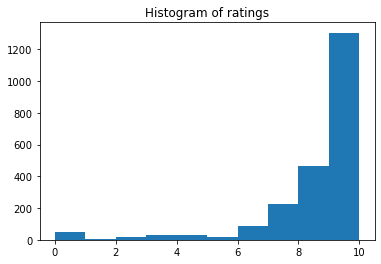

In [59]:
plt.hist(rated_clean['rating'])
plt.title('Histogram of ratings')
plt.show()

In [ ]:
We can see the data are highly skewed.

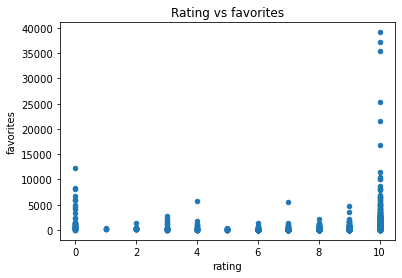

In [24]:
rated_clean.plot.scatter(x='rating',y='favorites')
plt.title('Rating vs favorites')
plt.show()

In [8]:
# Display image
# def display_image(df, record):
#     image_url = df.image_url.iloc[record]
#     text = df.tweet_text.iloc[record]
#     view_img = Image.open(requests.get(image_url, stream=True).raw)

#     fig, ax = plt.subplots()
#     plt.title('Room Rater Review')
#     fig.text(.5,.07, text, ha='center', fontsize=9)
#     plt.imshow(view_img)
#     ax.set_axis_off()
#     plt.axis('off')
    
#     return plt.show()

def view_tweet(df, tweet_id):
    """Input tweet id and receive image and caption associated with tweet"""
    
    image_url = df.loc[df['tweet_id'] == tweet_id, 'image_url'].iloc[0]
    text = df.loc[df['tweet_id'] == tweet_id, 'tweet_text'].iloc[0]
    view_img = Image.open(requests.get(image_url, stream=True).raw)

    fig, ax = plt.subplots()
    plt.title('Room Rater Review')
    fig.text(.5,.07, text, ha='center', fontsize=9)
    plt.imshow(view_img)
    ax.set_axis_off()
    plt.axis('off')
    
    return plt.show()
# https://stackoverflow.com/questions/7391945/how-do-i-read-image-data-from-a-url-in-python
# https://stackoverflow.com/questions/36684013/extract-column-value-based-on-another-column-pandas-dataframe

In [34]:
rated_clean.describe()['rating']

count    2241.000000
mean        8.348059
std         2.051406
min         0.000000
25%         8.000000
50%         9.000000
75%        10.000000
max        10.000000
Name: rating, dtype: float64

In [156]:
# Store the min, median, and max ratings
min_rating = rated_clean.rating.quantile(0)
q1_rating = rated_clean.rating.quantile(.25)
q2_rating = rated_clean.rating.quantile(.5)
max_rating = rated_clean.rating.quantile(1)

In [170]:
# Select a tweet from 
min_ex = rated_clean.query('rating == @min_rating').iloc[1][0]
q1_ex = rated_clean.query('rating == @q1_rating').iloc[0][0]
q2_ex = rated_clean.query('rating == @q2_rating').iloc[0][0]
max_ex = rated_clean.query('rating == @max_rating').iloc[0][0]

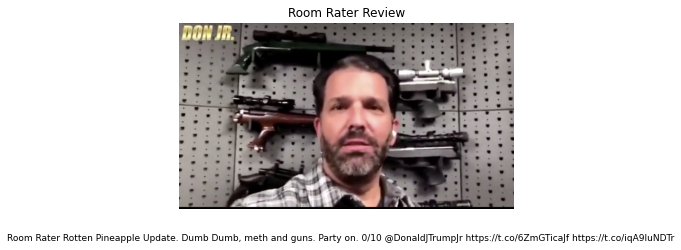

In [162]:
# RoomRater reserves 0 rating for people they despise
view_tweet(rated_clean, min_ex)

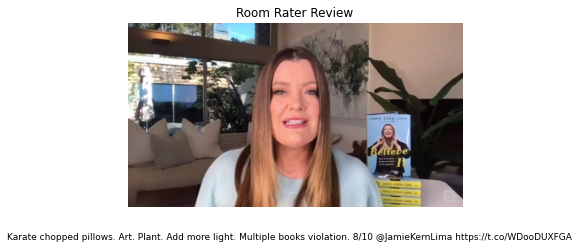

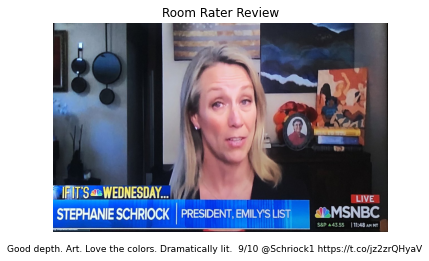

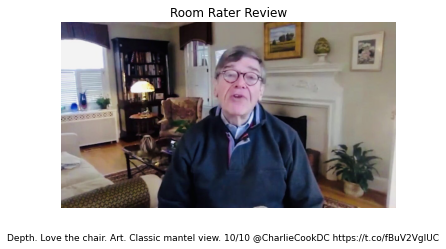

In [171]:
# Most other users get scores of 8 and above. Let's take a closer look at what distinguishes an 8, 9, and 10
view_tweet(rated_clean, q1_ex)
view_tweet(rated_clean, q2_ex)
view_tweet(rated_clean, max_ex)

Looks like there's a little more nuance to what sets a 10, 9, and 8 apart from each other.

## Data Preprocessing

In [9]:
def tokenize(text):
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    stop_words = stopwords.words("english")
    
    # Remove URLs
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, " ")
        
    lemmatizer = WordNetLemmatizer()
    
    # Normalize case and remove punctuation and extra spaces
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower().strip())
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

## NLP: Implementation and Refinement

In [10]:
# Backup
# def build_model():
#     """Use Pipeline to build Classifier with parameters selected based on GridSearch"""
#     pipeline = Pipeline([
# #         ('features', FeatureUnion([
            
#             ('text_pipeline', Pipeline([
#                 ('vect', CountVectorizer(tokenizer=tokenize)),
#                 ('tfidf', TfidfTransformer())
# #             ])),
            
# #             ('id_question', QuestionDetector())
#         ])),
        
#         ('clf', RandomForestClassifier(random_state=random_state))
#     ])
    
#     # After multiple runs with GridSerachCV, store best parameters in final model
#     best_parameters = {
#         'clf__min_samples_split': [2]
#     }
    
#     cv = GridSearchCV(pipeline, param_grid = best_parameters, verbose=3)
    
#     return cv

In [ ]:
def build_model():
    """Use Pipeline to build Classifier with parameters selected based on GridSearch"""
    pipeline = Pipeline([
            
            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
        ])),
        
        ('clf', RandomForestClassifier(random_state=random_state))
    ])
    
    # After multiple runs with GridSerachCV, store best parameters in final model
    best_parameters = {
        'clf__min_samples_split': [2]
    }
    
    cv = GridSearchCV(pipeline, param_grid = best_parameters, verbose=3)
    
    return cv

In [11]:
X = rated_clean['tweet_text']
y = rated_clean['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
model = build_model()

In [27]:
model.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__text_pipeline', 'estimator__clf', 'estimator__text_pipeline__memory', 'estimator__text_pipeline__steps', 'estimator__text_pipeline__verbose', 'estimator__text_pipeline__vect', 'estimator__text_pipeline__tfidf', 'estimator__text_pipeline__vect__analyzer', 'estimator__text_pipeline__vect__binary', 'estimator__text_pipeline__vect__decode_error', 'estimator__text_pipeline__vect__dtype', 'estimator__text_pipeline__vect__encoding', 'estimator__text_pipeline__vect__input', 'estimator__text_pipeline__vect__lowercase', 'estimator__text_pipeline__vect__max_df', 'estimator__text_pipeline__vect__max_features', 'estimator__text_pipeline__vect__min_df', 'estimator__text_pipeline__vect__ngram_range', 'estimator__text_pipeline__vect__preprocessor', 'estimator__text_pipeline__vect__stop_words', 'estimator__text_pipeline__vect__strip_accents', 'estimator__text_pipeline__vect__token_pattern', 'estim

In [13]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\laure\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


[CV 1/5] END .......................clf__min_samples_split=2; total time=   2.5s
[CV 2/5] END .......................clf__min_samples_split=2; total time=   1.1s
[CV 3/5] END .......................clf__min_samples_split=2; total time=   1.1s
[CV 4/5] END .......................clf__min_samples_split=2; total time=   1.0s
[CV 5/5] END .......................clf__min_samples_split=2; total time=   1.1s


GridSearchCV(estimator=Pipeline(steps=[('text_pipeline',
                                        Pipeline(steps=[('vect',
                                                         CountVectorizer(tokenizer=<function tokenize at 0x0000026C8EE78CA0>)),
                                                        ('tfidf',
                                                         TfidfTransformer())])),
                                       ('clf',
                                        RandomForestClassifier(random_state=5))]),
             param_grid={'clf__min_samples_split': [2]}, verbose=3)

## Model Evaluation and Validation

In [15]:
# def evaluate_model(model, X_test, y_test):
#     """Input model, X_test, y_test, and category names to return classification report for each category"""
#     y_pred = model.predict(X_test)
    
#     classif_report = classification_report(y_test, y_pred)
    
#     return classif_report

In [64]:
def print_scores(y_test, y_pred):
    """Input y_test, y_pred, return model performance scores"""
    
    print('r2 score: ', sklearn.metrics.r2_score(y_test, y_pred))
    print('accuracy score: ', accuracy_score(y_test, y_pred))
    print('precision score: ', precision_score(y_test, y_pred, average='weighted'))
    print('recall score: ', recall_score(y_test, y_pred, average='weighted'))

In [65]:
y_pred = model.predict(X_test)

In [66]:
print_scores(y_test, y_pred)

r2 score:  0.847065771052067
accuracy score:  0.9799554565701559
precision score:  0.9737290806735823
recall score:  0.9799554565701559


C:\Users\laure\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## View results

In [54]:
pred_df = rated_clean.copy()
pred_df['preds'] = pd.Series(y_pred)

# Calculate difference between actual and predicted rating
pred_df['diff'] = pred_df['rating']-pred_df['preds']
pred_df.sort_values(by=['diff'], ascending=False).head()

,tweet_id,tweet_text,image_url,favorites,rating,preds
0,1364758339079479296,Depth. Love the chair. Art. Classic mantel vie...,http://pbs.twimg.com/media/EvCYedsVkAAhmnb.jpg,189,10,8.0
1,1364755341175480323,Karate chopped pillows. Art. Plant. Add more l...,http://pbs.twimg.com/media/EvCVv9bUYAE-SQx.jpg,111,8,7.0
2,1364730053234290690,Room Rater Fluffy Room. A pineapple can be so ...,http://pbs.twimg.com/media/EvB-v_8VoAcqEHy.jpg,949,10,10.0
3,1364700539817058311,Revisiting. Top room with a view. Plants. Lamp...,http://pbs.twimg.com/media/EvBj5-CVIAMXgzm.jpg,117,10,9.0
4,1364699445883932673,Checking in. Mantel view. Shapes. Art. Lightin...,http://pbs.twimg.com/media/EvBi6UiVkAYI82Q.jpg,380,10,8.0


In [56]:
def view_heatmap(pred_df):
    """Input pred_df return heatmap comparing actual with predicted ratings"""
    sum_df = pd.DataFrame(pred_df[['rating','preds','tweet_id']].groupby(by=['rating', 'preds']).count()
                          .reset_index())

    sum_df = sum_df.rename(columns={'tweet_id':'count'})

    sum_pivot = sum_df.pivot('rating','preds','count')

    ax = sns.heatmap(sum_pivot, annot=True, cmap = 'YlGnBu')
    ax.invert_yaxis()
    plt.title('Actual v Predicted Rating: # Tweets')
    plt.show()

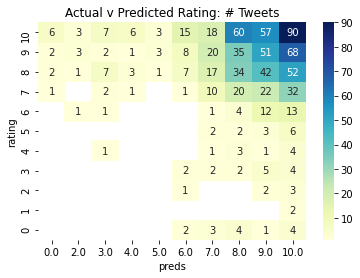

In [57]:
view_heatmap(pred_df)

As we saw similar precision and recall scores, the model is just as likely to underpredict as it is to overpredict.

## Improving Model with SMOTE

In [152]:
# Attempt 1
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.pipeline import make_pipeline as make_pipeline_sk

def build_model_smote():
    """Use Pipeline to build Classifier with parameters selected based on GridSearch"""
    pipeline = make_pipeline_imb([
        SMOTE(),
        make_pipeline_sk([
            CountVectorizer(tokenizer=tokenize),
            TfidfTransformer()
        ]),      
        RandomForestClassifier(random_state=random_state)
    ])
    
    best_parameters = {
        'min_samples_split': [2]
    }
    
    cv = GridSearchCV(pipeline, param_grid = best_parameters, verbose=3)
    
    return cv

In [146]:
# Attempt 2
def build_model_smote():
    """Use Pipeline to build Classifier with parameters selected based on GridSearch"""
    pipeline = sklearn.pipeline.Pipeline([
#         ('oversample',SMOTE()),
        ('smote_pipeline', imblearn.pipeline.Pipeline([
                ('oversample', SMOTE())
            ]))
                ,
#         ('features', FeatureUnion([
                
        ('text_pipeline', sklearn.pipeline.Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer()),
            ])),           
        
#         ])),
        
        ('clf', RandomForestClassifier(random_state=random_state))
    ])
    
    # After multiple runs with GridSerachCV, store best parameters in final model
    best_parameters = {
        'clf__min_samples_split': [2]
    }
    
    cv = GridSearchCV(pipeline, param_grid = best_parameters, verbose=3)
    
    return cv

In [ ]:
#Attempt 3

SMOTE = SMOTE.fit_sample()

def build_model_smote():
    """Use Pipeline to build Classifier with parameters selected based on GridSearch"""
    pipeline = sklearn.pipeline.Pipeline([
#         ('oversample',SMOTE()),
        ('smote_pipeline', imblearn.pipeline.Pipeline([
                ('oversample', SMOTE())
            ]))
                ,
#         ('features', FeatureUnion([
                
        ('text_pipeline', sklearn.pipeline.Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer()),
            ])),           
        
#         ])),
        
        ('clf', RandomForestClassifier(random_state=random_state))
    ])
    
    # After multiple runs with GridSerachCV, store best parameters in final model
    best_parameters = {
        'clf__min_samples_split': [2]
    }
    
    cv = GridSearchCV(pipeline, param_grid = best_parameters, verbose=3)
    
    return cv

In [153]:
X1 = rated_clean['tweet_text']
y1 = rated_clean['rating']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2)

model1 = build_model_smote()

model1.fit(X_train1, y_train1)

TypeError: Last step of Pipeline should implement fit or be the string 'passthrough'. '[CountVectorizer(tokenizer=<function tokenize at 0x0000026C8EE78CA0>), TfidfTransformer()]' (type <class 'list'>) doesn't

In [143]:
y_pred1 = model1.predict(X_test1)

print_scores(y_test1, y_pred1)

NotFittedError: Vocabulary not fitted or provided

## Improving Model Further

Let's assume that you are not a despicable person in the eyes of RoomRater. If we were to exclude scores of 0 from the model, since they are usually due to poor decorum rather than poor decor, can we perform even better?

In [187]:
rated_filtered = rated_clean.query('rating > 0')
rated_filtered.describe()

,tweet_id,favorites,rating
count,2.193000e+03,2193.000000,2193.000000
mean,1.375599e+18,542.235294,8.530780
std,1.697750e+16,1815.357717,1.655583
min,1.347386e+18,0.000000,1.000000
25%,1.357854e+18,109.000000,8.000000
50%,1.382486e+18,194.000000,9.000000
75%,1.390139e+18,410.000000,10.000000
max,1.398334e+18,39160.000000,10.000000


In [190]:
X2 = rated_filtered['tweet_text']
y2 = rated_filtered['rating']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2)

model2 = build_model()

model2.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\laure\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


[CV 1/5] END .......................clf__min_samples_split=2; total time=   2.4s
[CV 2/5] END .......................clf__min_samples_split=2; total time=   2.4s
[CV 3/5] END .......................clf__min_samples_split=2; total time=   2.4s
[CV 4/5] END .......................clf__min_samples_split=2; total time=   2.4s
[CV 5/5] END .......................clf__min_samples_split=2; total time=   2.4s


GridSearchCV(estimator=Pipeline(steps=[('text_pipeline',
                                        Pipeline(steps=[('vect',
                                                         CountVectorizer(tokenizer=<function tokenize at 0x00000257920A3040>)),
                                                        ('tfidf',
                                                         TfidfTransformer())])),
                                       ('clf',
                                        RandomForestClassifier(random_state=5))]),
             param_grid={'clf__min_samples_split': [2]}, verbose=3)

In [203]:
y_pred2 = model2.predict(X_test2)

print_scores(y_test2, y_pred2)

r2 score:  0.9886534439292843
accuracy score:  0.9954441913439636
precision score:  0.9955070300840468
recall score:  0.9954441913439636


In [196]:
rated_copy2 = rated_filtered.copy()
rated_copy2['preds'] = pd.Series(y_pred2)
rated_copy2['diff'] = rated_copy2['rating']-rated_copy2['preds']
rated_copy2.sort_values(by=['diff'], ascending=False).head(15)

,tweet_id,tweet_text,image_url,favorites,rating,preds,diff
429,1357479946306916363,Good bookwall. Assuming poetry. Nice spacing. ...,http://pbs.twimg.com/media/Eta80RSXUAQEDK3.jpg,156,9,1.0,8.0
192,1395784271735017477,Room Rater fortune favors the bold colors. And...,http://pbs.twimg.com/media/E17SZZGXEAUjmPI.jpg,133,10,2.0,8.0
31,1364035743442558979,Room Rater Fluffy Rooms. This seems wonderfull...,http://pbs.twimg.com/media/Eu4HR14VIAQmEBT.jpg,35517,10,2.0,8.0
429,1392863967681318913,Classic library set up. We heart books. A few ...,http://pbs.twimg.com/media/E1RyZSXXEAEdtKM.jpg,173,9,1.0,8.0
304,1359208953343803396,Books. Flowers. Portuguese Water Dogs are art....,http://pbs.twimg.com/media/EtzhVu8XcAM6qTh.jpg,7849,10,3.0,7.0
389,1393302553039867905,Good kitchen set up. We remain pro knife block...,http://pbs.twimg.com/media/E1YBSPyXMA8yZjA.jpg,171,9,2.0,7.0
31,1397938126241386498,Revisiting a good stair view. Hoping to spot M...,http://pbs.twimg.com/media/E2Z5UOuXIAM6Bls.jpg,89,9,2.0,7.0
192,1361416987906215936,Plant is perkier. More art now in view. Better...,http://pbs.twimg.com/media/EuS5iMyXEAcGiw3.jpg,115,9,2.0,7.0
131,1396493795798274052,Great piano view. Depth. Couch. Pillow. Lamp. ...,http://pbs.twimg.com/media/E2FXtMYX0AUEvxr.jpg,131,10,3.0,7.0
389,1358047560901029893,Love the wall art. Pro textiles. Couch view. V...,http://pbs.twimg.com/media/EtjBDs5XUAoDhus.jpg,236,9,2.0,7.0


In [201]:
orig_filtered = rated_copy.query('rating > 0')
print('original avg diff w/0: ', rated_copy['diff'].mean())

# Since including 0 increases the maximum difference to 10, let's look at the original difference for ratings > 0
print('original avg diff w/o 0: ', orig_filtered['diff'].mean())

print('new avg diff: ', rated_copy2['diff'].mean())

original avg diff w/0:  -0.26211180124223604
original avg diff w/o 0:  -0.11125158027812895
new avg diff:  -0.05966277561608301


### Justification 

[Why some techniques worked better than others or how improvements were made]

## Conclusion

### Reflection

### Improvement

The data set is highly skewed, with X percent receiving the maximum rating of 10. 